<a href="https://colab.research.google.com/github/nneamakao/churn-prediction/blob/main/ChurnModel_OgboguNI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q xlrd

## Library Importation

In [ ]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from scipy.stats.mstats import winsorize

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # K "Nearest Neighbours"
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.svm import SVC # Support Vector
from xgboost import XGBClassifier
from sklearn import model_selection

In [ ]:
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

In [ ]:
import math

In [ ]:
#Functions for Supervised Classification Performance Metrics

def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
    plt.show()

In [ ]:
# Configuration of Plots
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## Data Importation

The excel file is derived by running the following query:

SELECT 
	FIS.CustomerKey, 
	DATEDIFF(DAY, [DateFirstPurchase], '2014-01-28 00:00:00.000') AS DaysSinceFirstPurchase,
	DATEDIFF(YEAR, [BirthDate], '2014-01-28') AS Age,
	COUNT(DISTINCT [SalesOrderNumber]) AS NumberOfOrders,
	SUM([SalesAmount]) AS TotalSpent,
	DC.CommuteDistance, DC.EnglishEducation, DC.EnglishOccupation, DC.Gender, DC.HouseOwnerFlag, DC.MaritalStatus, DC.YearlyIncome, 
	DC.NumberChildrenAtHome, DC.TotalChildren, DC.NumberCarsOwned, 
	DG.EnglishCountryRegionName, 
	CASE WHEN 
		DATEDIFF(MONTH, MAX([OrderDate]), '2014-01-28 00:00:00.000') < 8
			THEN 0
	ELSE 1
	END AS Churn
FROM [dbo].[FactInternetSales] AS FIS
JOIN 
	[dbo].[DimCustomer] AS DC
ON 
	FIS.CustomerKey = DC.CustomerKey
JOIN 
	[dbo].[DimGeography] AS DG
ON 
	DC.GeographyKey = DG.GeographyKey
GROUP BY 
	FIS.[CustomerKey], DC.CommuteDistance, DC.EnglishEducation, DC.EnglishOccupation, DC.Gender, DC.HouseOwnerFlag, DC.MaritalStatus, DC.YearlyIncome, 
	DC.NumberChildrenAtHome, DG.EnglishCountryRegionName, DC.TotalChildren, DC.NumberCarsOwned, DC.DateFirstPurchase, DC.BirthDate ;

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving churndata2.xlsx to churndata2.xlsx


In [ ]:
churndata = pd.read_excel('churndata2.xlsx')

## Preliminary EDA

In [ ]:
# Check first few rows
churndata.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,EnglishOccupation,Gender,HouseOwnerFlag,MaritalStatus,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,EnglishCountryRegionName,Churn
0,11000,1105,43,3,8248.99,1-2 Miles,Bachelors,Professional,M,1,M,90000,0,2,0,Australia,1
1,11001,1109,38,3,6383.88,0-1 Miles,Bachelors,Professional,M,0,S,60000,3,3,1,Australia,0
2,11002,1117,43,3,8114.04,2-5 Miles,Bachelors,Professional,M,1,M,60000,3,3,1,Australia,1
3,11003,1126,41,3,8139.29,5-10 Miles,Bachelors,Professional,F,0,S,70000,0,0,1,Australia,1
4,11004,1101,35,3,8196.01,1-2 Miles,Bachelors,Professional,F,1,S,80000,5,5,4,Australia,1


In [ ]:
# Check dimensions
churndata.shape

(18484, 17)

In [ ]:
# Check how many customers did and did not churn
churndata['Churn'].value_counts()

0    12925
1     5559
Name: Churn, dtype: int64

In [ ]:
# Chech high level statistics of numerical columns
churndata.describe()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,HouseOwnerFlag,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,20241.500000,346.742372,45.176531,1.496375,1588.329216,0.676369,57305.777970,1.004058,1.844352,1.502705,0.300747
std,5336.015523,277.080410,11.536142,1.101139,2124.231717,0.467874,32285.841703,1.522660,1.612408,1.138394,0.458595
min,11000.000000,0.000000,28.000000,1.000000,2.290000,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000
25%,15620.750000,140.000000,36.000000,1.000000,49.970000,0.000000,30000.000000,0.000000,0.000000,1.000000,0.000000
50%,20241.500000,269.000000,43.000000,1.000000,270.265000,1.000000,60000.000000,0.000000,2.000000,2.000000,0.000000
75%,24862.250000,473.000000,53.000000,2.000000,2511.275000,1.000000,70000.000000,2.000000,3.000000,2.000000,1.000000
max,29483.000000,1126.000000,98.000000,28.000000,13295.380000,1.000000,170000.000000,5.000000,5.000000,4.000000,1.000000


In [ ]:
# Check high level statistics of non-numerical columns
churndata.describe(include = 'object')

,CommuteDistance,EnglishEducation,EnglishOccupation,Gender,MaritalStatus,EnglishCountryRegionName
count,18484,18484,18484,18484,18484,18484
unique,5,5,5,2,2,6
top,0-1 Miles,Bachelors,Professional,M,M,United States
freq,6310,5356,5520,9351,10011,7819


In [ ]:
# Check high level summary
churndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerKey               18484 non-null  int64  
 1   DaysSinceFirstPurchase    18484 non-null  int64  
 2   Age                       18484 non-null  int64  
 3   NumberOfOrders            18484 non-null  int64  
 4   TotalSpent                18484 non-null  float64
 5   CommuteDistance           18484 non-null  object 
 6   EnglishEducation          18484 non-null  object 
 7   EnglishOccupation         18484 non-null  object 
 8   Gender                    18484 non-null  object 
 9   HouseOwnerFlag            18484 non-null  int64  
 10  MaritalStatus             18484 non-null  object 
 11  YearlyIncome              18484 non-null  int64  
 12  NumberChildrenAtHome      18484 non-null  int64  
 13  TotalChildren             18484 non-null  int64  
 14  Number

In [ ]:
# check for missing values
churndata.isna().sum()

CustomerKey                 0
DaysSinceFirstPurchase      0
Age                         0
NumberOfOrders              0
TotalSpent                  0
CommuteDistance             0
EnglishEducation            0
EnglishOccupation           0
Gender                      0
HouseOwnerFlag              0
MaritalStatus               0
YearlyIncome                0
NumberChildrenAtHome        0
TotalChildren               0
NumberCarsOwned             0
EnglishCountryRegionName    0
Churn                       0
dtype: int64

## Copy Dataset

In [ ]:
# Make a copy of the dataset
churndata_ = churndata.copy()

In [ ]:
churndata_.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,EnglishOccupation,Gender,HouseOwnerFlag,MaritalStatus,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,EnglishCountryRegionName,Churn
0,11000,1105,43,3,8248.99,1-2 Miles,Bachelors,Professional,M,1,M,90000,0,2,0,Australia,1
1,11001,1109,38,3,6383.88,0-1 Miles,Bachelors,Professional,M,0,S,60000,3,3,1,Australia,0
2,11002,1117,43,3,8114.04,2-5 Miles,Bachelors,Professional,M,1,M,60000,3,3,1,Australia,1
3,11003,1126,41,3,8139.29,5-10 Miles,Bachelors,Professional,F,0,S,70000,0,0,1,Australia,1
4,11004,1101,35,3,8196.01,1-2 Miles,Bachelors,Professional,F,1,S,80000,5,5,4,Australia,1


## Churner/Non-Churner Profiling

In [ ]:
# Find average values of numerical features of churners
churndata_[(churndata_['Churn'] == 1)].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CustomerKey               21228.046591
DaysSinceFirstPurchase      443.214787
Age                          45.074294
NumberOfOrders                1.268214
TotalSpent                 1503.142648
HouseOwnerFlag                0.667026
YearlyIncome              55538.765965
NumberChildrenAtHome          0.917431
TotalChildren                 1.821191
NumberCarsOwned               1.466631
Churn                         1.000000
dtype: float64

In [ ]:
# Find modal non-numerical features of churners
churndata_[(churndata_['Churn'] == 1)].describe(include = 'object')

,CommuteDistance,EnglishEducation,EnglishOccupation,Gender,MaritalStatus,EnglishCountryRegionName
count,5559,5559,5559,5559,5559,5559
unique,5,5,5,2,2,6
top,0-1 Miles,Bachelors,Professional,M,M,United States
freq,1870,1570,1574,2826,2946,2623


In [ ]:
# Find average values of numerical features of non-churners
churndata_[(churndata_['Churn'] == 0)].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CustomerKey               19817.189555
DaysSinceFirstPurchase      305.249903
Age                          45.220503
NumberOfOrders                1.594507
TotalSpent                 1624.967678
HouseOwnerFlag                0.680387
YearlyIncome              58065.764023
NumberChildrenAtHome          1.041315
TotalChildren                 1.854313
NumberCarsOwned               1.518221
Churn                         0.000000
dtype: float64

In [ ]:
# Find modal non-numerical features of non-churners
churndata_[(churndata_['Churn'] == 0)].describe(include = 'object')

,CommuteDistance,EnglishEducation,EnglishOccupation,Gender,MaritalStatus,EnglishCountryRegionName
count,12925,12925,12925,12925,12925,12925
unique,5,5,5,2,2,6
top,0-1 Miles,Bachelors,Professional,M,M,United States
freq,4440,3786,3946,6525,7065,5196


Values are the same as for churners.


## Single Feature Plots 

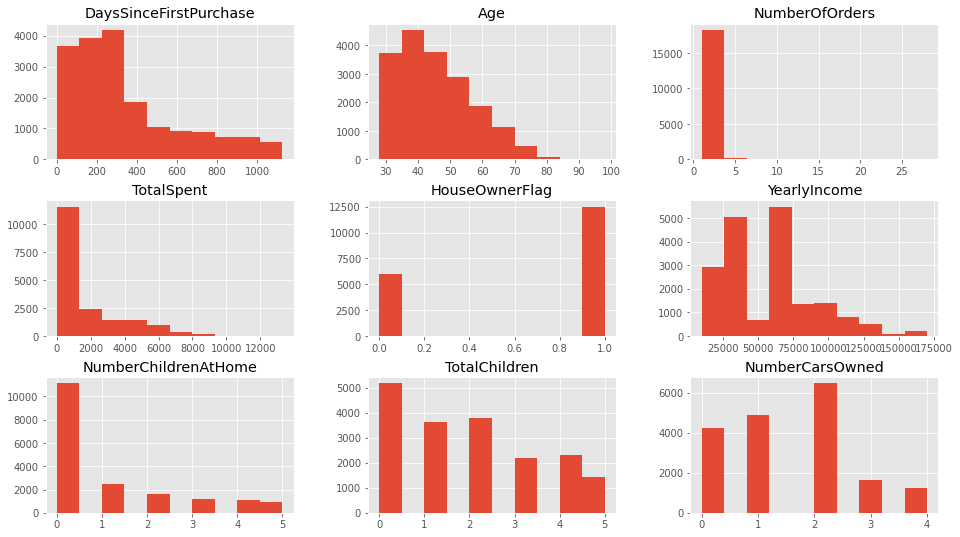

In [ ]:
churndata_.drop(['CustomerKey', 'Churn'], axis = 1).hist()
plt.show();

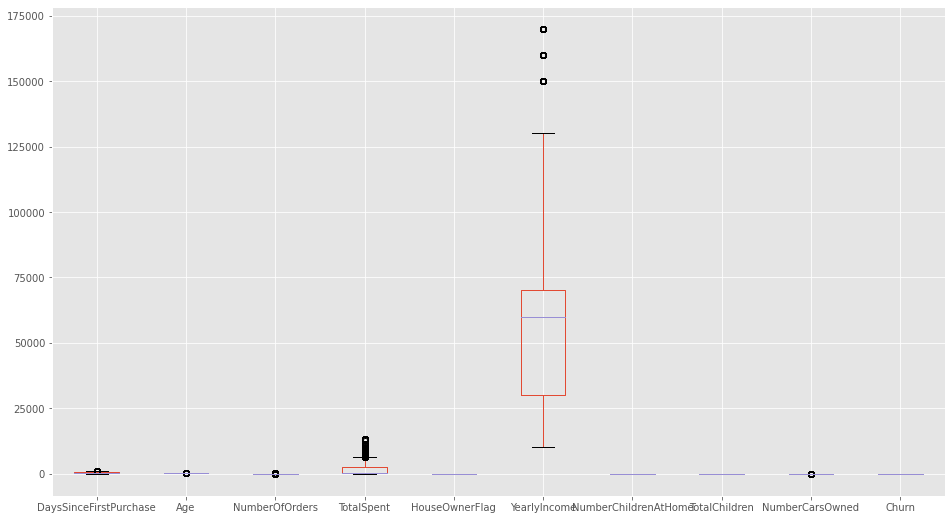

In [ ]:
churndata_.boxplot();

The boxplots above are squashed and difficult to see - 3 new boxplots are created for better visualisation.

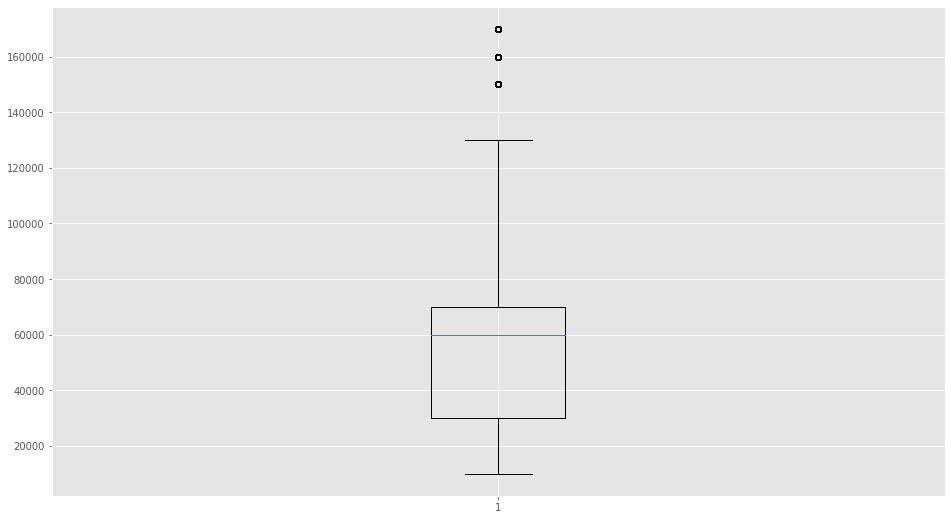

In [ ]:
plt.boxplot(churndata_['YearlyIncome'])
plt.show()

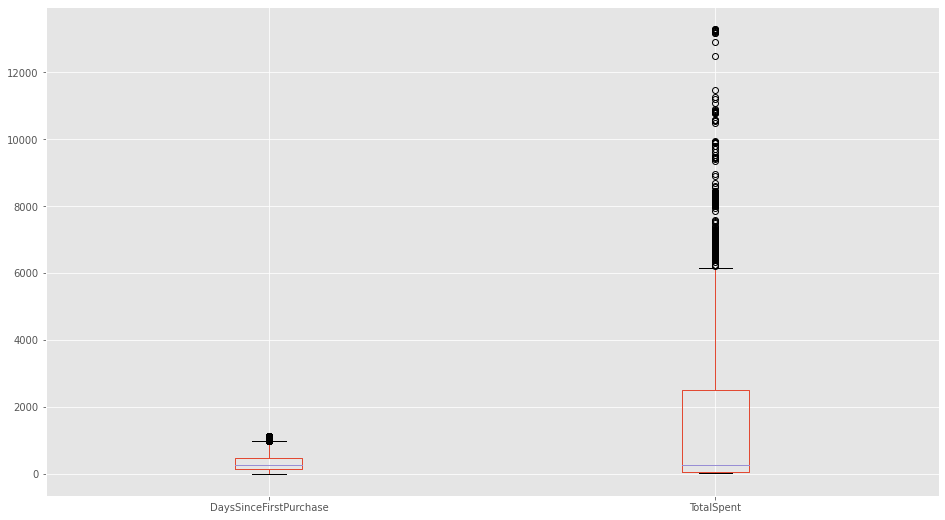

In [ ]:
churndata_[['DaysSinceFirstPurchase', 'TotalSpent']].boxplot();

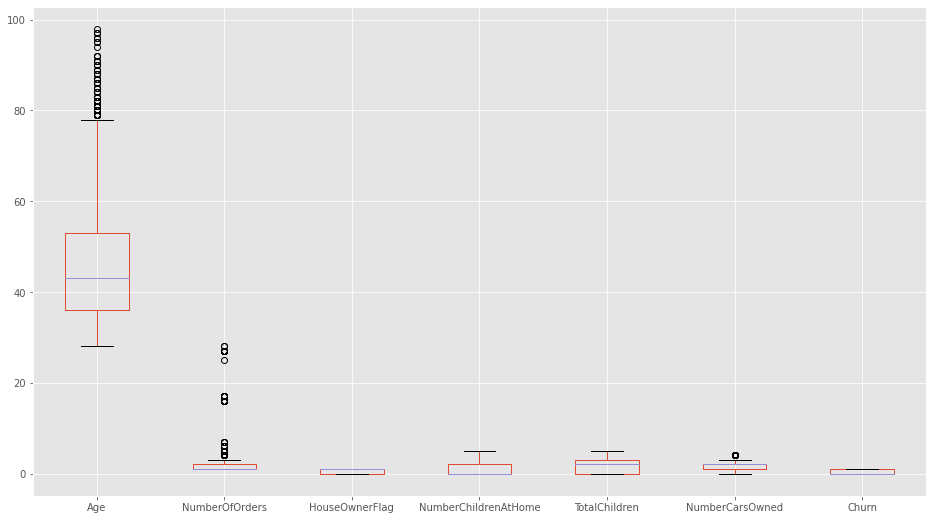

In [ ]:
churndata_.drop(['YearlyIncome', 'DaysSinceFirstPurchase', 'TotalSpent'], axis = 1).boxplot();

## Multi-Feature Analysis

In [ ]:
churndata_.columns

Index(['DaysSinceFirstPurchase', 'Age', 'NumberOfOrders', 'TotalSpent',
       'CommuteDistance', 'EnglishEducation', 'EnglishOccupation', 'Gender',
       'HouseOwnerFlag', 'MaritalStatus', 'YearlyIncome',
       'NumberChildrenAtHome', 'TotalChildren', 'NumberCarsOwned',
       'EnglishCountryRegionName', 'Churn'],
      dtype='object')

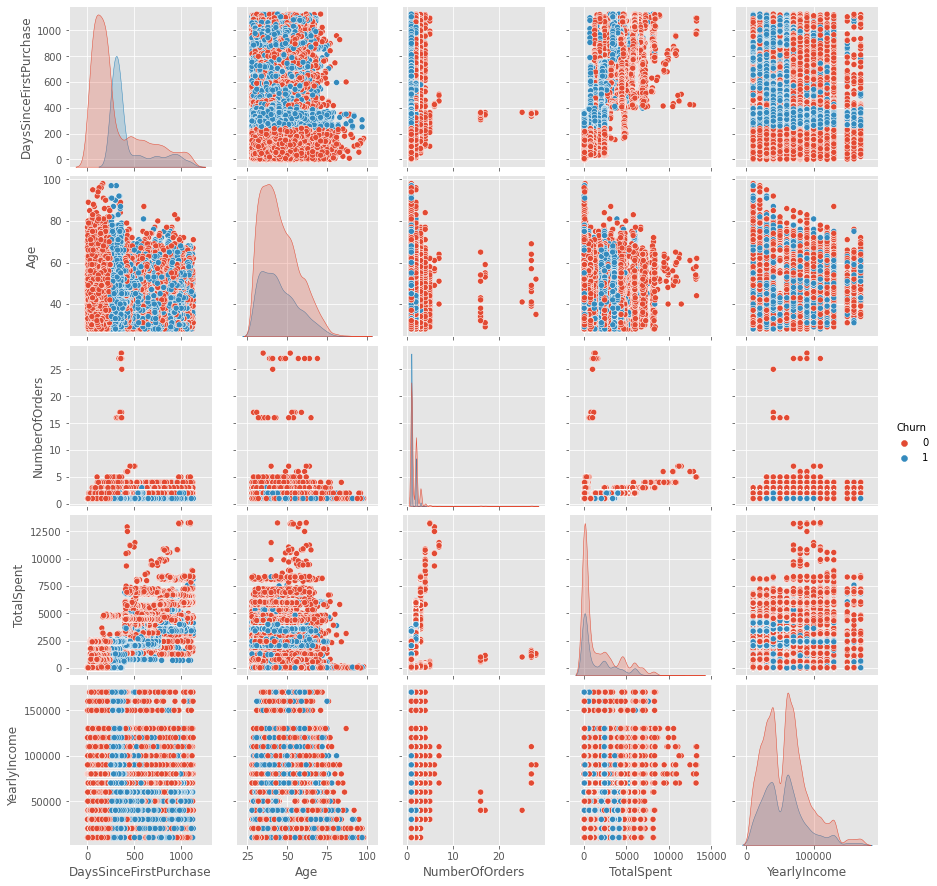

In [ ]:
# Pairplot of continuous numerical columns
sns.pairplot(churndata_[['DaysSinceFirstPurchase', 'Age', 'NumberOfOrders', 'TotalSpent', 'YearlyIncome', 'Churn']], hue = 'Churn');

## Feature Transformation

From the single and multi-feature plots, most of the numerical columns are right-skewed.

In [ ]:
# Check the actual skew values 
churndata_.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CustomerKey                0.000000
DaysSinceFirstPurchase     1.085679
Age                        0.704146
NumberOfOrders            12.579694
TotalSpent                 1.410328
HouseOwnerFlag            -0.753997
YearlyIncome               0.822122
NumberChildrenAtHome       1.393764
TotalChildren              0.472873
NumberCarsOwned            0.401767
Churn                      0.869067
dtype: float64

Acceptable skew values are between -0.5 and 0.5. Columns with values outside of this range (exclusing binary columns) are then transformed.

### DaysSinceFirstPurchase

In [ ]:
# Because this column is right-skewed and there are 0 values, the square root method is found to be the most ideal
churndata_['DaysSinceFirstPurchase'] = churndata_['DaysSinceFirstPurchase'] ** 0.5

In [ ]:
# Check new skew value
churndata_['DaysSinceFirstPurchase'].skew()

0.3630080309600487

### Age

In [ ]:
# No 0 values, so log transform may be used
churndata_['Age'] = np.log(churndata_['Age'])

# Check new skew value
churndata_['Age'].skew()

0.23685628851662166

### NumberOfOrders

In [ ]:
# Log transform gets this column closest to the range
churndata_['NumberOfOrders'] = np.log10(churndata_['NumberOfOrders'])

# Check new skew value
churndata_['NumberOfOrders'].skew()

1.2860441165707448

### TotalSpent

In [ ]:
# Use log transform
churndata_['TotalSpent'] = np.log10(churndata_['TotalSpent'])

# Check new skew value
churndata_['TotalSpent'].skew()

-0.11782784248053058

### YearlyIncome

In [ ]:
# Use square root method 
churndata_['YearlyIncome'] = churndata_['YearlyIncome'] ** (1/2)

# Check new skew value
churndata_['YearlyIncome'].skew()

0.09248156073821304

### NumberChildrenAtHome

In [ ]:
# Because this column has 0 values, log transforms cannot be used, but the cube root method gets the column closest to the desired range
churndata_['NumberChildrenAtHome'] = churndata_['NumberChildrenAtHome'] ** (1/3)

In [ ]:
# Check new skew value
churndata_['NumberChildrenAtHome'].skew()

0.5991857846343851

### New Plots

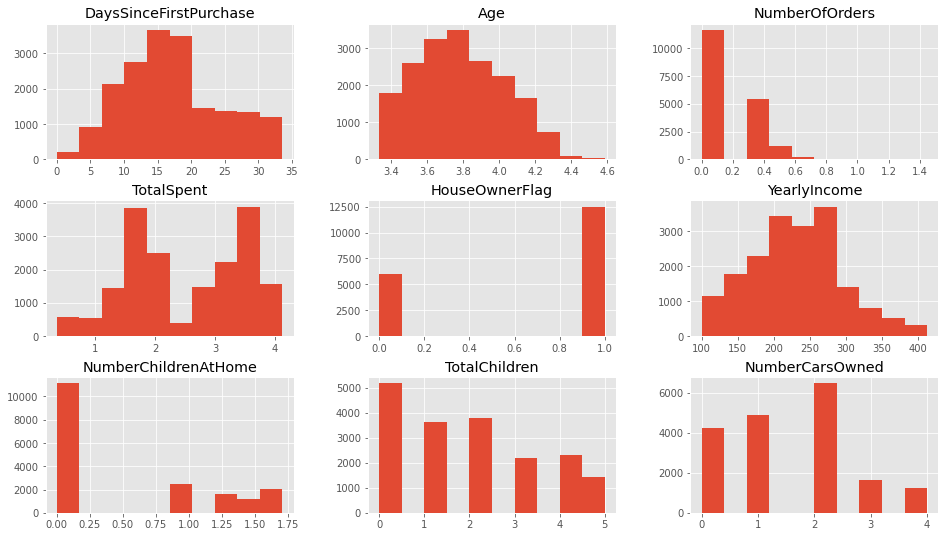

In [ ]:
churndata_.drop(['CustomerKey', 'Churn'], axis = 1).hist();

## Encoding 

In [ ]:
# Select columns that are non-numerical for encoding
churndata_.select_dtypes('object').columns

Index(['CommuteDistance', 'EnglishEducation', 'EnglishOccupation', 'Gender',
       'MaritalStatus', 'EnglishCountryRegionName'],
      dtype='object')

### CommuteDistance

In [ ]:
churndata_['CommuteDistance'].head()

0     1-2 Miles
1     0-1 Miles
2     2-5 Miles
3    5-10 Miles
4     1-2 Miles
Name: CommuteDistance, dtype: object

In [ ]:
# Check values of the CommuteDistance column
churndata_['CommuteDistance'].unique()

array(['1-2 Miles', '0-1 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles'],
      dtype=object)

In [ ]:
# Use ordinal encoding to map the values
churndata_.replace({'0-1 Miles': 1, '1-2 Miles': 2, '2-5 Miles': 3, '5-10 Miles': 4, '10+ Miles': 5}, inplace = True)

In [ ]:
# Check new values 
churndata_['CommuteDistance'].head()

0    2
1    1
2    3
3    4
4    2
Name: CommuteDistance, dtype: int64

### EnglishEducation

In [ ]:
# Check first few rows
churndata_['EnglishEducation'].head()

0    Bachelors
1    Bachelors
2    Bachelors
3    Bachelors
4    Bachelors
Name: EnglishEducation, dtype: object

In [ ]:
# Check values
churndata_['EnglishEducation'].unique()

array(['Bachelors', 'Partial College', 'High School',
       'Partial High School', 'Graduate Degree'], dtype=object)

In [ ]:
# Ordinal encoding can be used on this column
churndata_['EnglishEducation'].replace({'Partial High School': 1, 'High School': 2, 'Partial College': 3, 'Bachelors': 4, 'Graduate Degree': 5}, inplace = True)

In [ ]:
churndata_['EnglishEducation'].head()

0    4
1    4
2    4
3    4
4    4
Name: EnglishEducation, dtype: int64

### EnglishOccupation

In [ ]:
# Check first few rows
churndata_['EnglishOccupation'].head()

0    Professional
1    Professional
2    Professional
3    Professional
4    Professional
Name: EnglishOccupation, dtype: object

In [ ]:
# Check values
churndata_['EnglishOccupation'].unique()

array(['Professional', 'Management', 'Skilled Manual', 'Clerical',
       'Manual'], dtype=object)

In [ ]:
# One hot encoding is used since it is a categorical data type. In order to save memory, the first column is dropped from the resulting dataframe
occupation = pd.get_dummies(churndata_['EnglishOccupation'], drop_first = True)

# Check first few rows of resulting dataframe
occupation.head()

,Management,Manual,Professional,Skilled Manual
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [ ]:
# Combine new occupation dataset with original churn_data dataframe, drop original *EnglishOccupation* column
churndata_ = pd.concat([churndata_.drop('EnglishOccupation', axis = 1),
                        occupation], axis = 1)
# Check first few columns
churndata_.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,Gender,HouseOwnerFlag,MaritalStatus,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,EnglishCountryRegionName,Churn,Management,Manual,Professional,Skilled Manual
0,11000,33.241540,3.761200,0.477121,3.916401,2,4,M,1,M,300.000000,0.000000,2,0,Australia,1,0,0,1,0
1,11001,33.301652,3.637586,0.477121,3.805085,1,4,M,0,S,244.948974,1.442250,3,1,Australia,0,0,0,1,0
2,11002,33.421550,3.761200,0.477121,3.909237,3,4,M,1,M,244.948974,1.442250,3,1,Australia,1,0,0,1,0
3,11003,33.555923,3.713572,0.477121,3.910587,4,4,F,0,S,264.575131,0.000000,0,1,Australia,1,0,0,1,0
4,11004,33.181320,3.555348,0.477121,3.913602,2,4,F,1,S,282.842712,1.709976,5,4,Australia,1,0,0,1,0


### Gender

In [ ]:
# Check first few rows
churndata_['Gender'].head()

0    M
1    M
2    M
3    F
4    F
Name: Gender, dtype: object

In [ ]:
# Check value counts
churndata_['Gender'].value_counts()

M    9351
F    9133
Name: Gender, dtype: int64

In [ ]:
# Using leave-one-out encoding, create new Male column where male is 1 and female is 0 
churndata_['Male'] = churndata_.Gender.map(lambda gender: 1 if gender == 'M' else 0)

# Check new Male column
churndata_['Male'].head()

0    1
1    1
2    1
3    0
4    0
Name: Male, dtype: int64

In [ ]:
# Drop original Gender column
churndata_.drop(['Gender'], axis = 1, inplace = True)

# Check 
churndata_.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,HouseOwnerFlag,MaritalStatus,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,EnglishCountryRegionName,Churn,Management,Manual,Professional,Skilled Manual,Male
0,11000,33.241540,3.761200,0.477121,3.916401,2,4,1,M,300.000000,0.000000,2,0,Australia,1,0,0,1,0,1
1,11001,33.301652,3.637586,0.477121,3.805085,1,4,0,S,244.948974,1.442250,3,1,Australia,0,0,0,1,0,1
2,11002,33.421550,3.761200,0.477121,3.909237,3,4,1,M,244.948974,1.442250,3,1,Australia,1,0,0,1,0,1
3,11003,33.555923,3.713572,0.477121,3.910587,4,4,0,S,264.575131,0.000000,0,1,Australia,1,0,0,1,0,0
4,11004,33.181320,3.555348,0.477121,3.913602,2,4,1,S,282.842712,1.709976,5,4,Australia,1,0,0,1,0,0


### MaritalStatus	

In [ ]:
# First few rows
churndata_['MaritalStatus'].head()

0    M
1    S
2    M
3    S
4    S
Name: MaritalStatus, dtype: object

In [ ]:
# Check value counts
churndata_['MaritalStatus'].value_counts()

M    10011
S     8473
Name: MaritalStatus, dtype: int64

In [ ]:
# Using leave-one-out encoding, create new Married column where M is mapped to 1 and S to 0
churndata_['Married'] = churndata_.MaritalStatus.map(lambda maritalstatus: 1 if maritalstatus == 'M' else 0)

# Check first few rows
churndata_['Married'].head()

0    1
1    0
2    1
3    0
4    0
Name: Married, dtype: int64

In [ ]:
# Drop original MaritalStatus column
churndata_.drop('MaritalStatus', axis = 1, inplace = True)

# Check
churndata_.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,HouseOwnerFlag,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,EnglishCountryRegionName,Churn,Management,Manual,Professional,Skilled Manual,Male,Married
0,11000,33.241540,3.761200,0.477121,3.916401,2,4,1,300.000000,0.000000,2,0,Australia,1,0,0,1,0,1,1
1,11001,33.301652,3.637586,0.477121,3.805085,1,4,0,244.948974,1.442250,3,1,Australia,0,0,0,1,0,1,0
2,11002,33.421550,3.761200,0.477121,3.909237,3,4,1,244.948974,1.442250,3,1,Australia,1,0,0,1,0,1,1
3,11003,33.555923,3.713572,0.477121,3.910587,4,4,0,264.575131,0.000000,0,1,Australia,1,0,0,1,0,0,0
4,11004,33.181320,3.555348,0.477121,3.913602,2,4,1,282.842712,1.709976,5,4,Australia,1,0,0,1,0,0,0


### EnglishCountryRegionName

In [ ]:
churndata_['EnglishCountryRegionName'].head()

0    Australia
1    Australia
2    Australia
3    Australia
4    Australia
Name: EnglishCountryRegionName, dtype: object

In [ ]:
# Check values
churndata_['EnglishCountryRegionName'].unique()

array(['Australia', 'United States', 'Canada', 'Germany',
       'United Kingdom', 'France'], dtype=object)

In [ ]:
# Because the values are categorical, one hot encoding is used. The first column is dropped from the resulting dataframe in order to save memory
country = pd.get_dummies(churndata_['EnglishCountryRegionName'], drop_first = True)

# Check resulting dataframe
country.head()

,Canada,France,Germany,United Kingdom,United States
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [ ]:
# Combine churn_data with country dataframe, drop original EnglishCountryRegionName column
churndata_ = pd.concat([churndata_.drop('EnglishCountryRegionName', axis = 1),
                        country], 
                       axis = 1)

# Check
churndata_.head()

,CustomerKey,DaysSinceFirstPurchase,Age,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,HouseOwnerFlag,YearlyIncome,NumberChildrenAtHome,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,11000,33.241540,3.761200,0.477121,3.916401,2,4,1,300.000000,0.000000,...,0,1,0,1,1,0,0,0,0,0
1,11001,33.301652,3.637586,0.477121,3.805085,1,4,0,244.948974,1.442250,...,0,1,0,1,0,0,0,0,0,0
2,11002,33.421550,3.761200,0.477121,3.909237,3,4,1,244.948974,1.442250,...,0,1,0,1,1,0,0,0,0,0
3,11003,33.555923,3.713572,0.477121,3.910587,4,4,0,264.575131,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,11004,33.181320,3.555348,0.477121,3.913602,2,4,1,282.842712,1.709976,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Ensure all columns are of numerical data types
churndata_.dtypes

CustomerKey                 int64
DaysSinceFirstPurchase    float64
Age                       float64
NumberOfOrders            float64
TotalSpent                float64
CommuteDistance             int64
EnglishEducation            int64
HouseOwnerFlag              int64
YearlyIncome              float64
NumberChildrenAtHome      float64
TotalChildren               int64
NumberCarsOwned             int64
Churn                       int64
Management                  uint8
Manual                      uint8
Professional                uint8
Skilled Manual              uint8
Male                        int64
Married                     int64
Canada                      uint8
France                      uint8
Germany                     uint8
United Kingdom              uint8
United States               uint8
dtype: object

## Correlation

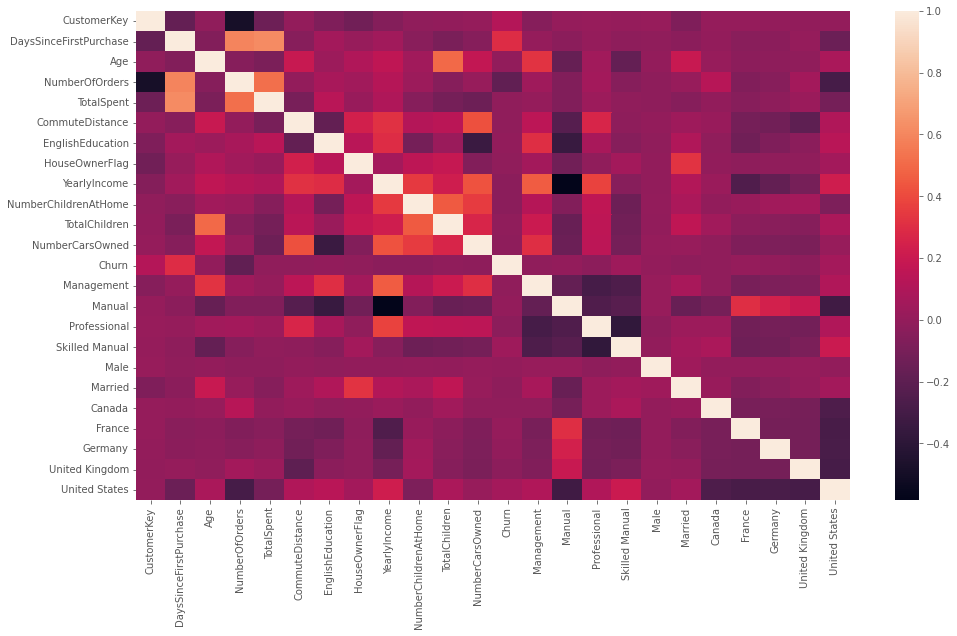

In [ ]:
sns.heatmap(churndata_.corr());

In [ ]:
# NumberOfOrders and DaysSinceFirstPurchase columns appear to be highly correlated - check actual value
(churndata_['NumberOfOrders'].corr(churndata_['DaysSinceFirstPurchase']))

0.597582571046523

In [ ]:
# Same thing for TotalSpent and DaysSinceFirstPurchase
(churndata_['TotalSpent'].corr(churndata_['DaysSinceFirstPurchase']))

0.6214054243976727

Because the correlation coefficients are less than 0.7, these columns are not too highly correlated.

## Test for Multicollinearity

In [ ]:
# Function to find VIF of the variables to ensure no variable is influencing others due to their correlation
def calc_VIF(x):
  vif = pd.DataFrame()
  vif['Features'] = x.columns
  vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

  return(vif)

In [ ]:
# Define x i.e. the feature set
x = churndata_.drop(['CustomerKey', 'Churn'], axis = 1)
# Calculate VIF
calc_VIF(x)

,Features,VIF
0,DaysSinceFirstPurchase,12.845246
1,Age,60.877196
2,NumberOfOrders,2.848132
3,TotalSpent,14.490671
4,CommuteDistance,7.110352
5,EnglishEducation,16.369878
6,HouseOwnerFlag,4.190291
7,YearlyIncome,47.865966
8,NumberChildrenAtHome,2.758520
9,TotalChildren,3.699750


In [ ]:
# Drop Age column since it has the highest VIF value
churndata1 = churndata_.drop('Age', axis = 1)

In [ ]:
# Calculate VIF of new dataframe
# Redefine x
x = churndata1.drop(['CustomerKey', 'Churn'], axis = 1)

calc_VIF(x)

,Features,VIF
0,DaysSinceFirstPurchase,12.325245
1,NumberOfOrders,2.802840
2,TotalSpent,13.999907
3,CommuteDistance,6.340534
4,EnglishEducation,13.160090
5,HouseOwnerFlag,4.190282
6,YearlyIncome,40.089527
7,NumberChildrenAtHome,2.627487
8,TotalChildren,3.270499
9,NumberCarsOwned,5.518103


In [ ]:
# Drop YearlyIncome column as its VIF is still very high
churndata2 = churndata1.drop('YearlyIncome', axis = 1)
churndata2.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,TotalSpent,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,11000,33.241540,0.477121,3.916401,2,4,1,0.000000,2,0,...,0,1,0,1,1,0,0,0,0,0
1,11001,33.301652,0.477121,3.805085,1,4,0,1.442250,3,1,...,0,1,0,1,0,0,0,0,0,0
2,11002,33.421550,0.477121,3.909237,3,4,1,1.442250,3,1,...,0,1,0,1,1,0,0,0,0,0
3,11003,33.555923,0.477121,3.910587,4,4,0,0.000000,0,1,...,0,1,0,0,0,0,0,0,0,0
4,11004,33.181320,0.477121,3.913602,2,4,1,1.709976,5,4,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Calculate VIF of new dataframe
# Redefine x, and calculate vif
x = churndata2.drop(['CustomerKey', 'Churn'], axis = 1)
calc_VIF(x)

,Features,VIF
0,DaysSinceFirstPurchase,12.224577
1,NumberOfOrders,2.802192
2,TotalSpent,13.249483
3,CommuteDistance,6.175893
4,EnglishEducation,10.493970
5,HouseOwnerFlag,4.179252
6,NumberChildrenAtHome,2.406573
7,TotalChildren,3.222913
8,NumberCarsOwned,4.564996
9,Management,3.551011


In [ ]:
# Drop TotalSpent column
churndata3 = churndata2.drop('TotalSpent', axis = 1)

In [ ]:
# Calculate VIF of new dataframe
# Redefine x, and calculate vif
x = churndata3.drop(['CustomerKey', 'Churn'], axis = 1)
calc_VIF(x)

,Features,VIF
0,DaysSinceFirstPurchase,8.570007
1,NumberOfOrders,2.684930
2,CommuteDistance,6.166404
3,EnglishEducation,9.797087
4,HouseOwnerFlag,4.176933
5,NumberChildrenAtHome,2.405786
6,TotalChildren,3.219527
7,NumberCarsOwned,4.562067
8,Management,3.551011
9,Manual,1.764581


All the VIF values are now less than 10, so they are acceptable.

In [ ]:
# Copy churndata3
churndata_ = churndata3.copy()

In [ ]:
churndata_.columns

Index(['CustomerKey', 'DaysSinceFirstPurchase', 'NumberOfOrders',
       'CommuteDistance', 'EnglishEducation', 'HouseOwnerFlag',
       'NumberChildrenAtHome', 'TotalChildren', 'NumberCarsOwned', 'Churn',
       'Management', 'Manual', 'Professional', 'Skilled Manual', 'Male',
       'Married', 'Canada', 'France', 'Germany', 'United Kingdom',
       'United States'],
      dtype='object')

## Partition Data

In [ ]:
# Create dataframe of only customers that churned
churners = churndata_[(churndata_['Churn'] == 1)]
churners.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,11000,33.241540,0.477121,2,4,1,0.000000,2,0,1,...,0,1,0,1,1,0,0,0,0,0
2,11002,33.421550,0.477121,3,4,1,1.442250,3,1,1,...,0,1,0,1,1,0,0,0,0,0
3,11003,33.555923,0.477121,4,4,0,0.000000,0,1,1,...,0,1,0,0,0,0,0,0,0,0
4,11004,33.181320,0.477121,2,4,1,1.709976,5,4,1,...,0,1,0,0,0,0,0,0,0,0
5,11005,33.541020,0.477121,4,4,1,0.000000,0,1,1,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
# Check that the number of churners is correct
len(churners)

5559

In [ ]:
# Create dataframe of customers that did not churn
nonchurners = churndata_[(churndata_['Churn'] == 0)]
nonchurners.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
1,11001,33.301652,0.477121,1,4,0,1.44225,3,1,0,...,0,1,0,1,0,0,0,0,0,0
12,11012,17.832555,0.301030,2,4,1,0.00000,2,2,0,...,0,0,0,0,1,0,0,0,0,1
13,11013,17.029386,0.301030,1,4,1,0.00000,2,3,0,...,0,0,0,1,1,0,0,0,0,1
17,11017,33.346664,0.477121,4,2,1,0.00000,4,2,0,...,0,0,1,0,0,0,0,0,0,0
18,11018,33.271610,0.477121,4,3,1,0.00000,2,2,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Check the number of non-churners
len(nonchurners)

12925

In [ ]:
# Shuffle non churners dataset
nonchurners = nonchurners.sample(frac = 1, random_state = 100).reset_index()
nonchurners.head()

,index,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,4734,15734,19.974984,0.301030,5,1,1,1.709976,0,4,...,0,1,0,0,1,0,0,0,0,0
1,2609,13609,13.190906,0.301030,5,2,1,1.709976,5,4,...,0,0,0,1,1,0,0,0,1,0
2,2109,13109,24.269322,0.477121,1,4,1,0.000000,1,1,...,0,1,0,0,1,0,0,0,0,0
3,569,11569,8.306624,0.000000,3,4,1,1.000000,1,1,...,0,0,0,1,1,0,0,0,1,0
4,12882,23882,6.928203,0.000000,1,5,1,0.000000,3,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
# Drop index column
nonchurners.drop(['index'], axis = 1, inplace = True)
nonchurners.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,15734,19.974984,0.301030,5,1,1,1.709976,0,4,0,...,0,1,0,0,1,0,0,0,0,0
1,13609,13.190906,0.301030,5,2,1,1.709976,5,4,0,...,0,0,0,1,1,0,0,0,1,0
2,13109,24.269322,0.477121,1,4,1,0.000000,1,1,0,...,0,1,0,0,1,0,0,0,0,0
3,11569,8.306624,0.000000,3,4,1,1.000000,1,1,0,...,0,0,0,1,1,0,0,0,1,0
4,23882,6.928203,0.000000,1,5,1,0.000000,3,0,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
# Split non-churners into two sets - one for model training (40%), and the other for scoring (60%).
# Define the 40% point at which the data is partitioned
split_point = round(0.4 * len(nonchurners))

In [ ]:
# Get the set for model training i.e. the first 40%
nonchurners_model = nonchurners[: split_point]

# Check length
len(nonchurners_model)

5170

In [ ]:
# Get the set for scoring i.e. the last 60%
nonchurners_score = nonchurners[split_point: ]

# Check length
len(nonchurners_score)

7755

In [ ]:
# Combine churner data and non churner modeling data to make up the datset for building the model
df_model = churners.append(nonchurners_model, ignore_index = True)

In [ ]:
# Check length
len(df_model)

10729

In [ ]:
df_model.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,11000,33.241540,0.477121,2,4,1,0.000000,2,0,1,...,0,1,0,1,1,0,0,0,0,0
1,11002,33.421550,0.477121,3,4,1,1.442250,3,1,1,...,0,1,0,1,1,0,0,0,0,0
2,11003,33.555923,0.477121,4,4,0,0.000000,0,1,1,...,0,1,0,0,0,0,0,0,0,0
3,11004,33.181320,0.477121,2,4,1,1.709976,5,4,1,...,0,1,0,0,0,0,0,0,0,0
4,11005,33.541020,0.477121,4,4,1,0.000000,0,1,1,...,0,1,0,1,0,0,0,0,0,0


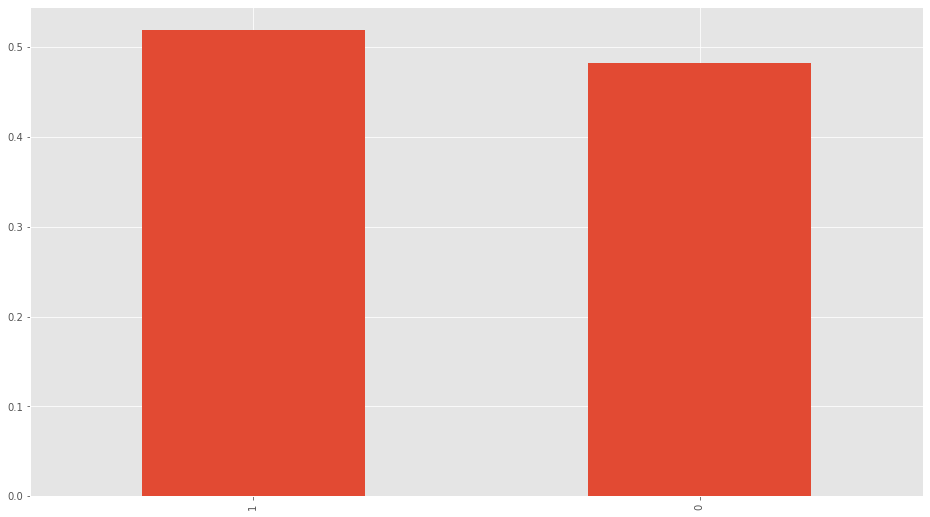

In [ ]:
df_model['Churn'].value_counts(normalize = True).plot(kind = 'bar');

No resampling required since the two classes are about the same size.

In [ ]:
# Drop CustomerKey column as it has no predictive value
df_model.drop(['CustomerKey'], axis = 1, inplace = True)
df_model.head(2)

,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,Management,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
0,33.24154,0.477121,2,4,1,0.00000,2,0,1,0,0,1,0,1,1,0,0,0,0,0
1,33.42155,0.477121,3,4,1,1.44225,3,1,1,0,0,1,0,1,1,0,0,0,0,0


## Split

In [ ]:
# Define X as the features i.e. all columns excluding the Churn column
X = df_model.loc[:, df_model.columns != 'Churn']

# Define y as the target variable
y = df_model['Churn']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.5,
                                                    random_state = 100)

In [ ]:
# Scale Data
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform training and testing features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Run 1 (Baseline Model) - All Features

In [ ]:
# Set up the model
log_reg = LogisticRegression(random_state = 100)

# Fit the model on training set
log_reg.fit(X_train, y_train)

# Predict using test set
y_pred = log_reg.predict(X_test)

#### Performance Metrics

In [ ]:
accuracy_score(y_test, y_pred)

0.8290773532152842

In [ ]:
recall_score(y_test, y_pred)

0.8874195854181558

In [ ]:
precision_score(y_test, y_pred)

0.8048622366288493

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Non Churner", "Churner"]))

              precision    recall  f1-score   support

 Non Churner       0.86      0.77      0.81      2567
     Churner       0.80      0.89      0.84      2798

    accuracy                           0.83      5365
   macro avg       0.83      0.83      0.83      5365
weighted avg       0.83      0.83      0.83      5365



In [ ]:
confusion_matrix(y_test, y_pred)

array([[1965,  602],
       [ 315, 2483]])

## Feature Selection using Decision Trees

### Build Model

In [ ]:
# Instantiate DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, random_state = 100)

# Fit model on training set
cart = classifier.fit(X_train, y_train)

# Make predictions using test set
y_pred_cart = cart.predict(X_test)

In [ ]:
# Check accuracy
accuracy_score(y_test, y_pred_cart)

0.8917054986020503

In [ ]:
recall_score(y_test, y_pred)

0.8874195854181558

In [ ]:
precision_score(y_test, y_pred)

0.8048622366288493

### Feature Importances

In [ ]:
# Get list of features
features = X.columns
features

Index(['DaysSinceFirstPurchase', 'NumberOfOrders', 'CommuteDistance',
       'EnglishEducation', 'HouseOwnerFlag', 'NumberChildrenAtHome',
       'TotalChildren', 'NumberCarsOwned', 'Management', 'Manual',
       'Professional', 'Skilled Manual', 'Male', 'Married', 'Canada', 'France',
       'Germany', 'United Kingdom', 'United States'],
      dtype='object')

In [ ]:
importances = cart.feature_importances_

In [ ]:
# Create series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values(ascending = False)

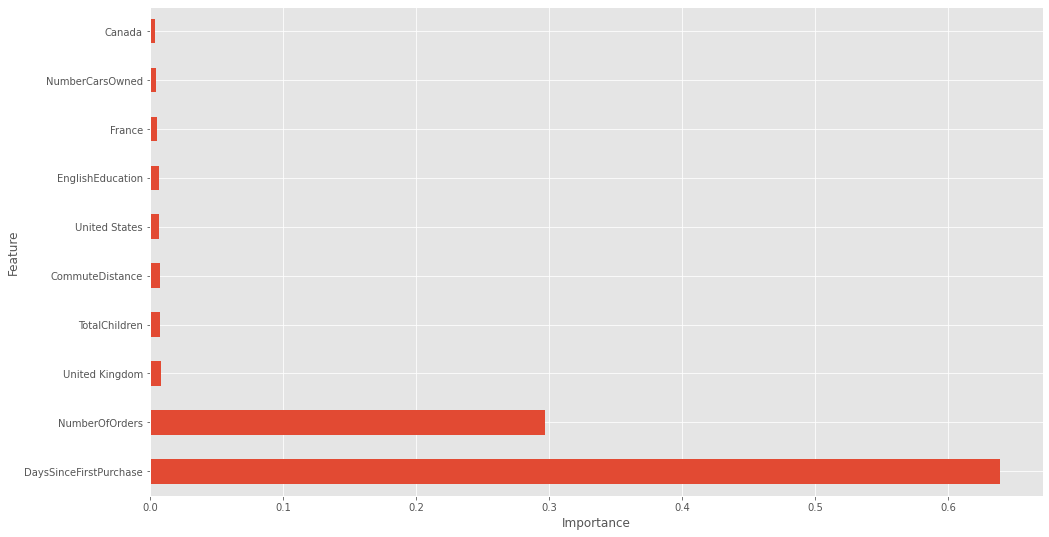

In [ ]:
# Make plot of top 10 most important features
feat_imp.head(10).plot(kind = 'barh')
plt.xlabel('Importance')
plt.ylabel('Feature');

In [ ]:
# Get list of top 10 most important features
feat_list = list(feat_imp.head(10).index)

In [ ]:
feat_list

['DaysSinceFirstPurchase',
 'NumberOfOrders',
 'United Kingdom',
 'TotalChildren',
 'CommuteDistance',
 'United States',
 'EnglishEducation',
 'France',
 'NumberCarsOwned',
 'Canada']

## Run 2 - Logistic Regression with Most Important Features

In [ ]:
# Redefine X using the most important features. y does not need to be redefined as the target remains the same
X = df_model[feat_list]
X.head()

,DaysSinceFirstPurchase,NumberOfOrders,United Kingdom,TotalChildren,CommuteDistance,United States,EnglishEducation,France,NumberCarsOwned,Canada
0,33.241540,0.477121,0,2,2,0,4,0,0,0
1,33.421550,0.477121,0,3,3,0,4,0,1,0
2,33.555923,0.477121,0,0,4,0,4,0,1,0
3,33.181320,0.477121,0,5,2,0,4,0,4,0
4,33.541020,0.477121,0,0,4,0,4,0,1,0


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.5,
                                                    random_state = 100)

In [ ]:
# Scale Data
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform training and testing features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Set up the model
log_reg = LogisticRegression(random_state = 100)

# Fit the model on the TRAINING set
log_reg.fit(X_train, y_train)

# Predict using the TEST set
y_pred = log_reg.predict(X_test)

# STEP 4 (optional) extract the classification PROBABILITIES in order to construct a ROC curve (later)
y_score = log_reg.predict_proba(X_test)[:,0]

In [ ]:
accuracy_score(y_test, y_pred)

0.828331780055918

In [ ]:
recall_score(y_test, y_pred)

0.8859899928520372

In [ ]:
precision_score(y_test, y_pred)

0.8046088932164882

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Non Churner", "Churner"]))

              precision    recall  f1-score   support

 Non Churner       0.86      0.77      0.81      2567
     Churner       0.80      0.89      0.84      2798

    accuracy                           0.83      5365
   macro avg       0.83      0.83      0.83      5365
weighted avg       0.83      0.83      0.83      5365



Although not by much, the model with all the features included performed better.

## Parallel Model Runs

In [ ]:
# Prepare Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))

# Evaluate each model in terms of accuracy
results = []
names = []
scoring = 'accuracy' 

for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.789908 (0.113118)
LDA: 0.776856 (0.120344)
KNN: 0.774816 (0.060416)
CART: 0.837639 (0.121670)
RF: 0.835032 (0.137320)
NB: 0.653272 (0.097817)
XGB: 0.793647 (0.135588)


Decision Trees and Random Forest give the best accuracies.

## Run 3 - Decision Tree Classifier with Most Important Features

In [ ]:
# Instantiate DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, random_state = 100)

# Fit model on training set
cart = classifier.fit(X_train, y_train)

# Make predictions using test set
y_pred_cart = cart.predict(X_test)

In [ ]:
# Check accuracy
accuracy_score(y_test, y_pred_cart)

0.8907735321528425

In [ ]:
precision_score(y_test, y_pred_cart)

0.9195751138088012

In [ ]:
recall_score(y_test, y_pred_cart)

0.8663330950679057

In [ ]:
print(classification_report(y_test, y_pred_cart, target_names=["Non Churner", "Churner"]))

              precision    recall  f1-score   support

 Non Churner       0.86      0.92      0.89      2567
     Churner       0.92      0.87      0.89      2798

    accuracy                           0.89      5365
   macro avg       0.89      0.89      0.89      5365
weighted avg       0.89      0.89      0.89      5365



## Run 4 - Random Forest Classifier with Most Important Features

In [ ]:
# Instantiate RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth = 10, random_state = 100, n_jobs = -1)

# Fit model on training set
rfc = classifier.fit(X_train, y_train)

# Make predictions using test set
y_pred_rfc = rfc.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_rfc)

0.9012115563839702

In [ ]:
precision_score(y_test, y_pred_rfc)

0.9263157894736842

In [ ]:
recall_score(y_test, y_pred_rfc)

0.8806290207290922

In [ ]:
print(classification_report(y_test, y_pred_rfc, target_names=["Non Churner", "Churner"]))

              precision    recall  f1-score   support

 Non Churner       0.88      0.92      0.90      2567
     Churner       0.93      0.88      0.90      2798

    accuracy                           0.90      5365
   macro avg       0.90      0.90      0.90      5365
weighted avg       0.90      0.90      0.90      5365



## Final Model

The Random Forest Classifier with the top 10 most important features is chosen as the champion model.

In [ ]:
# Instantiate RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth = 10, random_state = 100, n_jobs = -1)

# Fit model on training set
rfc = classifier.fit(X_train, y_train)

# Make predictions using test set
y_pred_rfc = rfc.predict(X_test)

# Extract the classification probabilities in order to construct a ROC curve 
y_score = classifier.predict_proba(X_test)[:,0]

In [ ]:
accuracy_score(y_test, y_pred_rfc)

0.9012115563839702

In [ ]:
precision_score(y_test, y_pred_rfc)

0.9263157894736842

In [ ]:
recall_score(y_test, y_pred_rfc)

0.8806290207290922

In [ ]:
print(classification_report(y_test, y_pred_rfc, target_names=["Non Churner", "Churner"]))

              precision    recall  f1-score   support

 Non Churner       0.88      0.92      0.90      2567
     Churner       0.93      0.88      0.90      2798

    accuracy                           0.90      5365
   macro avg       0.90      0.90      0.90      5365
weighted avg       0.90      0.90      0.90      5365



In [ ]:
(confusion_matrix(y_test, y_pred_rfc))

array([[2371,  196],
       [ 334, 2464]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


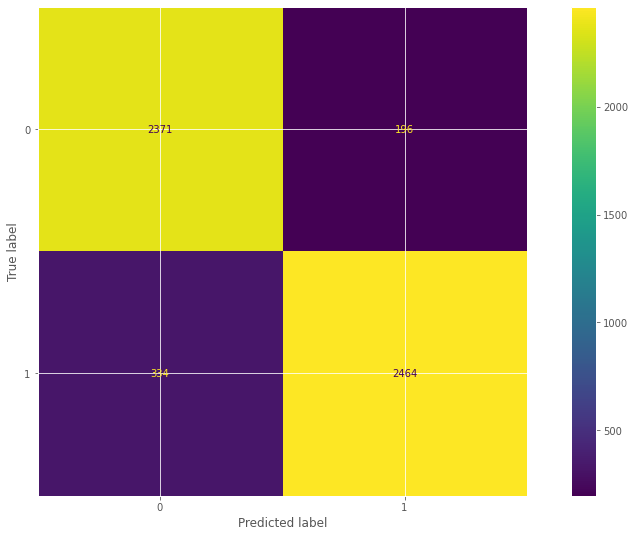

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test) 

## Score Model on 60% of Non-Churner Data

In [ ]:
nonchurners_score.head()

,CustomerKey,DaysSinceFirstPurchase,NumberOfOrders,CommuteDistance,EnglishEducation,HouseOwnerFlag,NumberChildrenAtHome,TotalChildren,NumberCarsOwned,Churn,...,Manual,Professional,Skilled Manual,Male,Married,Canada,France,Germany,United Kingdom,United States
5170,18833,7.071068,0.0,2,2,0,0.00000,2,2,0,...,0,1,0,0,1,0,0,0,0,1
5171,15855,10.954451,0.0,2,4,1,1.44225,4,0,0,...,0,0,0,1,1,0,0,0,0,1
5172,20523,7.874008,0.0,5,4,1,1.00000,2,0,0,...,0,0,0,0,1,0,0,0,0,1
5173,24464,15.099669,0.0,5,4,0,0.00000,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5174,23152,9.110434,0.0,1,4,1,1.00000,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
# Define X_scoring
X_scoring = nonchurners_score[feat_list]
X_scoring.head()

,DaysSinceFirstPurchase,NumberOfOrders,United Kingdom,TotalChildren,CommuteDistance,United States,EnglishEducation,France,NumberCarsOwned,Canada
5170,7.071068,0.0,0,2,2,1,2,0,2,0
5171,10.954451,0.0,0,4,2,1,4,0,0,0
5172,7.874008,0.0,0,2,5,1,4,0,0,0
5173,15.099669,0.0,0,0,5,0,4,0,1,0
5174,9.110434,0.0,0,1,1,1,4,0,1,0


In [ ]:
# Fit and transform data
X_scoring = scaler.fit_transform(X_scoring)

### Predicting Churn

In [ ]:
# Make predictions
predictions = pd.DataFrame(rfc.predict(X_scoring), columns =['Churn'])

In [ ]:
predictions.head()

,Churn
0,0
1,0
2,0
3,1
4,0


In [ ]:
customer_pred = pd.concat([nonchurners_score['CustomerKey'].reset_index(), 
                          predictions.reset_index()],
                          axis = 1)
customer_pred.head()

,index,CustomerKey,index,Churn
0,5170,18833,0,0
1,5171,15855,1,0
2,5172,20523,2,0
3,5173,24464,3,1
4,5174,23152,4,0


In [ ]:
# Drop index columns
customer_pred.drop(['index', 'index'], axis = 1, inplace = True)
customer_pred.head()

,CustomerKey,Churn
0,18833,0
1,15855,0
2,20523,0
3,24464,1
4,23152,0


In [ ]:
customer_pred['Churn'].value_counts()

0    5618
1    2137
Name: Churn, dtype: int64

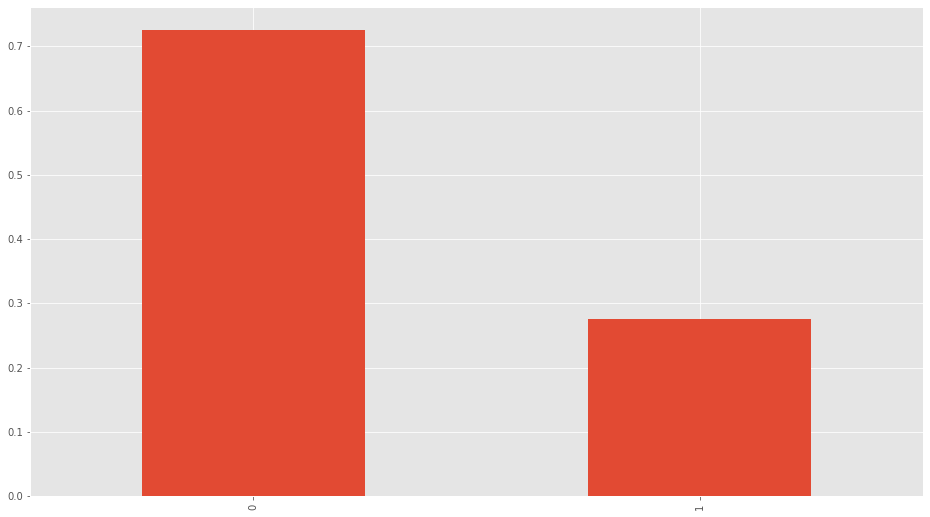

In [ ]:
# Check how many customers are predicted to churn
customer_pred['Churn'].value_counts(normalize = True).plot(kind = 'bar');

### Predicting Churn Propensity

In [ ]:
# Make predictions
propensity = pd.DataFrame(rfc.predict_proba(X_scoring), columns = ['No Churn', 'Churn'])
# Check first few rows
propensity.head()

,No Churn,Churn
0,0.983358,0.016642
1,0.968803,0.031197
2,0.987448,0.012552
3,0.011434,0.988566
4,0.974548,0.025452


In [ ]:
# Combine customer keys with their churn propensities
customer_prop = pd.concat([nonchurners_score['CustomerKey'].reset_index(), 
                          propensity.reset_index()],
                          axis = 1)
customer_prop.head()

,index,CustomerKey,index,No Churn,Churn
0,5170,18833,0,0.983358,0.016642
1,5171,15855,1,0.968803,0.031197
2,5172,20523,2,0.987448,0.012552
3,5173,24464,3,0.011434,0.988566
4,5174,23152,4,0.974548,0.025452


In [ ]:
# Drop index columns
customer_prop.drop(['index', 'index'], axis = 1, inplace = True)
customer_prop.head()

,CustomerKey,No Churn,Churn
0,18833,0.983358,0.016642
1,15855,0.968803,0.031197
2,20523,0.987448,0.012552
3,24464,0.011434,0.988566
4,23152,0.974548,0.025452


In [ ]:
# Return customers with churn propensity > 0.7
at_risk = customer_prop.drop(['No Churn'], axis = 1)[(customer_prop['Churn'] > 0.7)]

In [ ]:
at_risk.head()

,CustomerKey,Churn
3,24464,0.988566
7,28715,0.976640
14,22775,0.981482
20,23013,0.977182
24,16234,0.988438


In [ ]:
# Find number of customers at risk of churning
len(at_risk)

1379